In [1]:
import numpy as np
import os
import os.path
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import hog
from skimage.exposure import rescale_intensity
import random
from tqdm import tqdm

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install tqdm
# !pip install ipywidgets

In [3]:
dir = './Dataset_origin'

In [4]:
# создадим датафрем с нашими данными.
def create_df(directory):
    name = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            name.append([dirname.split('/')[-1], os.path.join(dirname, filename)])
    
    
    return pd.DataFrame(columns = ['category', 'way'], data = name)

df = create_df('./Dataset_origin')
df.shape

(117, 2)

In [5]:
# заменим категриальные признаки на числовые
slovar = {}
my_list = df['category'].unique()
for counter, value in enumerate(my_list):
    slovar[value] = counter

df['category'] = df['category'].map(slovar)

In [6]:
df.head()

,category,way
0,0,./Dataset_origin/fork/fork.jpg
1,0,./Dataset_origin/fork/IMG_20211120_173901.jpg
2,0,./Dataset_origin/fork/IMG_20211216_123250.jpg
3,0,./Dataset_origin/fork/IMG_20211130_220101.jpg
4,0,./Dataset_origin/fork/IMG_20211206_084314.jpg


In [7]:
np.round(df.groupby("category")["way"].count() / df.shape[0] * 100, 2)

category
0    13.68
1    20.51
2    17.95
3    17.09
4    14.53
5    16.24
Name: way, dtype: float64

Разделим выборку на train и val в пропорции 80:20. 

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, stratify = df["category"], random_state=1)

In [9]:
df_train.shape, df_val.shape

((93, 2), (24, 2))

К каждому изображению применим фильтр Гаусса для сглаживания, уменьшим его и нормируем яркость

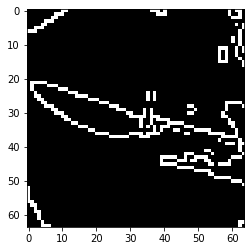

In [10]:
def first_prepare(img):
    # размытие (сглаживание)
    img = cv2.GaussianBlur(img, (35, 35), 9)

    
    # уменьшим размер
    img = cv2.resize(img, (64, 64))
    
    # найдем границы на изображении
    img = cv2.Canny(np.uint8(img), 200, 300)
    
    # нормализуем интенсивности от 0 до 255
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    
    return img

img = cv2.imread(df_train.iloc[18, 1], cv2.IMREAD_GRAYSCALE)

img = first_prepare(img)
plt.imshow(img, cmap="gray")

## Аугментация изображений

Аугментация будет включать в себя:
- случайный поворот на угол от -20 до +20 градусов
- случайное отображение относительно вертикальной оси

Аугментации будем делать "на лету", чтобы не хранить на диске большое количество фотографий и чтобы аугментированные фотографии попадали в обучающую или валидационную выборку вместе с исходным изображением.

In [11]:
def rot(image, angle=5, scale=1.0):
    # поворот
    return rotate(image, angle, resize=False, mode="edge") * 255

def flip(image, vflip=False, hflip=False):
    # перевернуть изображение
    if hflip or vflip:
        if hflip and vflip:
            c = -1
        else:
            c = 0 if vflip else 1
        image = cv2.flip(image, flipCode=c)
    return image 

def color(image_name):
    # поменяем матрицу hsv
    image = cv2.imread(image_name, cv2.COLOR_BGR2HSV) 
    h,s,v = cv2.split(image)
    new_image = cv2.merge((h+10,s-20,v+15))
    image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    return image

In [12]:
def augmentation(image_name, n_aug):
    
  # Augmentation для наших данных

    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)  
    file_name = image_name[len("./Dataset_origin"):-4]

    # случайный flip
    if (random.random() > 0.5):  
        image = flip(image, vflip=False, hflip=True)
    # случайный поворот
    angle = random.randint(-20, 20)
    image = rot(image, angle=angle)
    #img_gaussian = add_GaussianNoise(img)
    
    image = rescale_intensity(image, out_range=(0, 255))

    return image

## Bag of words для исходной картинки (несегментированной)

### Составление словаря слов
Каждую картинку (исходный размер 64х64) разделим на ячейки 16х16 со смещением 8 пикселей. Итого получим 49 ячеек. 

Для каждой из них вычислим гистограмму направленных градиентов HOG по 9 направлением. Итого каждый объект (слово) будет представлять из себя вектор длины 9, из каждой картинки получим 49 слов.

Все слова из всех картинок разделим на кластеры с помощью алгоритмя K-means (количество кластеров попробуем разное, для начала - 25 штук).
Тогда наш словарь будет состоять из 25 слов.

In [13]:
def get_frames(image, image_name):
    # получает 49 векторов длины 9 из каждой картинки
    # и возвращает dataframe с этими векторами
    
    # исходный размер изображения 64*64
    win_size = (64, 64)
    block_size = (16, 16) # (8, 8)
    block_stride = (8, 8) # (4, 4)
    cell_size = (16, 16) # (8, 8)
    n_bins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, n_bins)

    winStride = (8, 8) # (4, 4) 
    padding = (0, 0) 
    hist = hog.compute(image, winStride, padding) 

    # количество ячеек 7 * 7, по 9 бинов в каждом = 441
    # сделаем resize в матрицу 49*9, чтобы каждая ячейка (слово) описывалась отдельно
    
    data = np.reshape(hist, (49, 9)) # (225, 9))
    df = pd.DataFrame(data)
    df["row"] = df.index % 7 # 15 
    df["col"] = df.index // 7 # 15 
    df["name"] = image_name
    
    return df[["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8]]

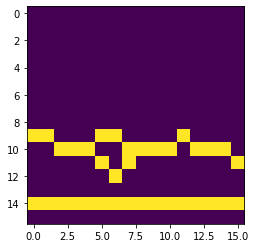

In [14]:
def frame_image(name, row, col):
    # по имени файла, номеру строки (от 0 до 6),
    # номеру колонки (от 0 до 6)
    # возвращает фрагмент изображения
    
    image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    image = first_prepare(image)
    # для получения сегментированного изображения
#     image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 33, 24)
    
    frame = image[row * 8 : (row + 2) * 8, col * 8 : (col + 2) * 8]
    # frame = image[row * 4 : (row + 2) * 4, col * 4 : (col + 2) * 4]
    return frame

# пример работы функции
plt.imshow(frame_image("./Dataset_origin/fork/IMG_20211119_084920.jpg", 2, 3))

In [15]:
# обучим K-means на наших данных
from sklearn.cluster import KMeans


n_augmentations = 10


# сформируем список файлов
file_list = df_train["way"].to_list()

# сформируем dataframe со словами, из него для обучения возьмем только часть колонок 
# название файла и месторасположение фрагмента не берем

train_frames_data = pd.DataFrame(columns=["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8])

for file in tqdm(file_list):
    for i_augment in range(n_augmentations):
        img = augmentation(file, i_augment) if i_augment > 0 else cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        aug_name = file + "_" + str(i_augment)
        img = first_prepare(img)

        train_frames_data = pd.concat([train_frames_data, get_frames(img, aug_name)], axis=0)

train_frames_data.reset_index(drop=True, inplace=True)        
X_hog_train = train_frames_data[[0, 1, 2, 3, 4, 5, 6, 7, 8]]




100%|███████████████████████████████████████████| 93/93 [21:51<00:00, 14.10s/it]


In [16]:
n_clusters = 30
cls = KMeans(n_clusters=n_clusters)

# обучим алгоритм
cls.fit(X_hog_train)

KMeans(n_clusters=30)

In [17]:
train_frames_data.shape

(45570, 12)

Посмотрим на получившиеся кластеры. Для этого в dataframe с информацией о фрагментах всех изображений добавим значение кластера.

И посмотрим на объемы кластеров.

In [18]:
train_frames_data["cluster"] = cls.predict(X_hog_train)

train_frames_data["cluster"].value_counts()

1     11715
10     2847
8      2674
9      2639
24     2050
2      1937
5      1883
27     1868
22     1630
28     1548
20     1533
3      1528
18     1151
7      1073
6      1030
4       971
11      809
14      781
29      775
17      702
0       667
26      657
15      633
21      403
12      402
19      374
23      362
16      346
13      301
25      281
Name: cluster, dtype: int64

Видно, что есть один наиболее многочисленный кластер и 24 менее многочисленных.

Для визуальной оценки кластеров возьмем несколько фрагментов самого многочисленного кластера:

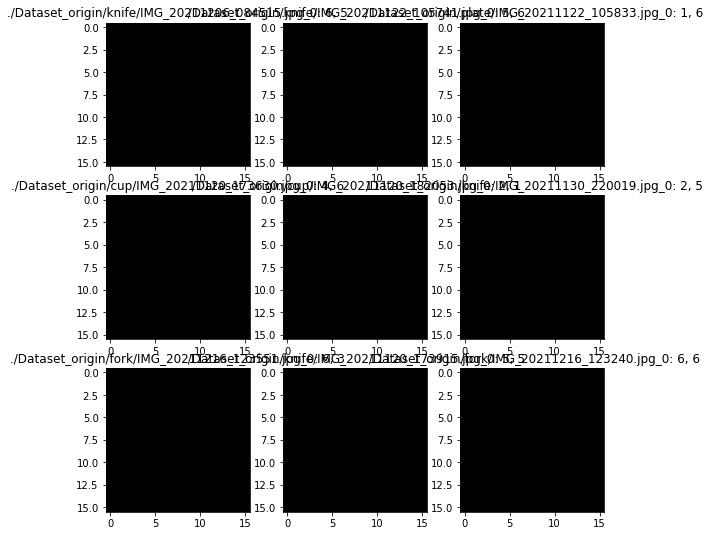

In [19]:
cluster = 1

origin_mask = train_frames_data["name"].apply(lambda x: ".jpg_0" in x)
not_aug_frames = train_frames_data[origin_mask]

sample = not_aug_frames[not_aug_frames["cluster"] == cluster].sample(n=9)
sample.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(9, 9))

for i in range(9):
    name = sample.loc[i, "name"]
    row = sample.loc[i, "row"]
    col = sample.loc[i, "col"]

    plt.subplot(3, 3, i + 1)
    plt.imshow(frame_image(name[:-2], row, col), cmap='gray')
    plt.title(f"{name}: {row}, {col}")


И какого-нибудь кластера среднего размера

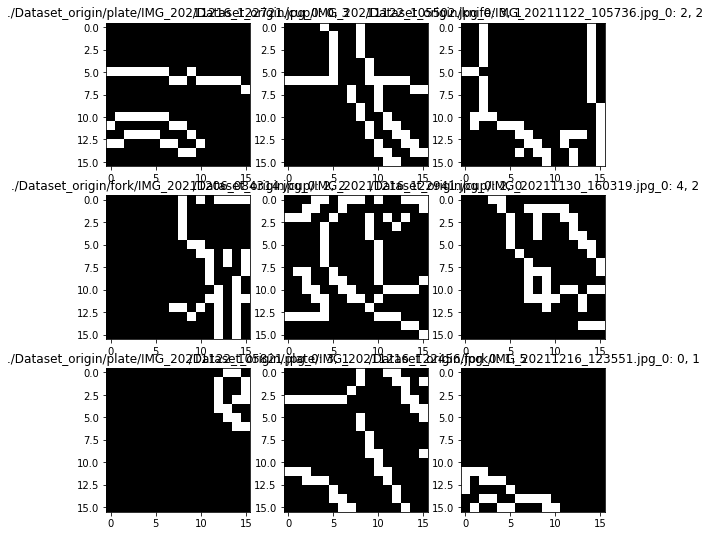

In [20]:
cluster = 3

sample = not_aug_frames[not_aug_frames["cluster"] == cluster].sample(n=9)
sample.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(9, 9))

for i in range(9):
    name = sample.loc[i, "name"]
    row = sample.loc[i, "row"]
    col = sample.loc[i, "col"]
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(frame_image(name[:-2], row, col), cmap='gray')
    plt.title(f"{name}: {row}, {col}")

### Построение feature vector для изображений

Теперь мы можем посмотреть на все 49 фрагментов изображения и определить, к какому из кластеров они относятся и записать частоту этого слова в соответствующую ячейку.

Так как наш словарь включает в себя 25 слов, то каждое изображение можно описать вектором длины 25, где на i-м месте стоит частота i-го слова.

Информация о номере кластера для каждого фрагмента каждого изображения у нас уже записана в dataframe, нам нужно только группировать ее по названию файла.

In [21]:
def create_features(data, vocab_volume):
    df_counts = (data[["name", "cluster", "row"]]
                 .groupby(["name", "cluster"], as_index=False)
                 .agg("count")
    )
    df_counts = df_counts.rename(columns={"row": "count"})
    # проверка на присутствие всех кластеров
    names_list = df_counts["name"].unique()
    for name in names_list:
        values_list = df_counts[df_counts["name"] == name]["cluster"].to_list() 
        for i in range(vocab_volume):          
            if i not in values_list:
                df_counts = df_counts.append({"name": name, "cluster": i, "count": 0}, ignore_index=True)
    
    
    df_counts_wide = df_counts.pivot_table(index=["name"], 
                                           columns=["cluster"], 
                                           values=["count"], 
                                           fill_value=0)
    df_counts_wide.columns = df_counts_wide.columns.get_level_values(1)
    
    
    return df_counts_wide


features_train = create_features(train_frames_data, n_clusters)
features_train.head()

cluster,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
name,,,,,,,,,,,,,,,,,,,,,
./Dataset_origin/cup/IMG_20211120_173630.jpg_0,0,12,1,5,4,1,4,3,5,5,...,0,0,2,0,2,0,0,1,0,2
./Dataset_origin/cup/IMG_20211120_173630.jpg_1,0,11,2,2,0,2,4,2,1,4,...,2,0,2,2,0,0,0,0,2,2
./Dataset_origin/cup/IMG_20211120_173630.jpg_2,1,11,1,4,1,0,5,1,4,3,...,0,0,0,0,2,0,1,3,1,3
./Dataset_origin/cup/IMG_20211120_173630.jpg_3,1,13,2,4,0,1,1,5,9,1,...,0,0,0,1,0,0,2,3,3,0
./Dataset_origin/cup/IMG_20211120_173630.jpg_4,0,13,0,4,1,2,2,7,7,2,...,0,0,1,0,1,0,3,1,1,2


Теперь нужно склеить полученное описание с целевой переменной.

In [22]:
features_train["origin_name"] = features_train.index
features_train["origin_name"] = features_train["origin_name"].apply(lambda x: x[:x.rfind("_")])
data_train = pd.merge(features_train, df_train, 
                      left_on="origin_name", right_on="way").drop(["way", "origin_name"], axis=1)
data_train.reset_index(drop=True, inplace=True)

In [23]:
y_train = data_train.pop("category")
X_train = data_train

In [24]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,12,1,5,4,1,4,3,5,5,...,0,0,2,0,2,0,0,1,0,2
1,0,11,2,2,0,2,4,2,1,4,...,2,0,2,2,0,0,0,0,2,2
2,1,11,1,4,1,0,5,1,4,3,...,0,0,0,0,2,0,1,3,1,3
3,1,13,2,4,0,1,1,5,9,1,...,0,0,0,1,0,0,2,3,3,0
4,0,13,0,4,1,2,2,7,7,2,...,0,0,1,0,1,0,3,1,1,2


In [25]:
X_train.shape

(930, 30)

In [26]:
y_train.head()

0    3
1    3
2    3
3    3
4    3
Name: category, dtype: int64

In [27]:
# сформируем X_val и y_val, объединим проделанную процедуру в функцию

def create_xy_data(df, clf_model):
    # df - dataframe именами файлов и категориями
    # clf_model - модель кластеризации
    
    file_list = df["way"].to_list()
    
    df_frames = pd.DataFrame(columns=["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8])

    for file in tqdm(file_list):
        for i_augment in range(n_augmentations):
            img = augmentation(file, i_augment) if i_augment > 0 else cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            aug_name = file + "_" + str(i_augment)
            img = first_prepare(img)

            df_frames = pd.concat([df_frames, get_frames(img, aug_name)], axis=0)

    df_frames.reset_index(drop=True, inplace=True)        

    df_hog = df_frames[[0, 1, 2, 3, 4, 5, 6, 7, 8]]
    
    df_frames["cluster"] = clf_model.predict(df_hog)
    features = create_features(df_frames, clf_model.get_params()["n_clusters"])
    features["origin_name"] = features.index
    features["origin_name"] = features["origin_name"].apply(lambda x: x[:x.rfind("_")])
    data = pd.merge(features, df, 
                      left_on="origin_name", right_on="way").drop(["way", "origin_name"], axis=1)
    
    data.reset_index(drop=True, inplace=True)
    y = data.pop("category")
    X = data 
    return X, y

X_val, y_val = create_xy_data(df_val, cls)


100%|███████████████████████████████████████████| 24/24 [06:25<00:00, 16.06s/it]


In [28]:
X_val.shape

(240, 30)

In [41]:
# обучим SVM и XGBoost на наших данных

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_svc = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', SVC(C=1))])


pipe_svc.fit(X_train, y_train)

pipe_xgbst = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', XGBClassifier(n_estimators=10, max_depth=4, verbosity=0))])


pipe_svc.fit(X_train, y_train)
pipe_xgbst.fit(X_train, y_train)


Pipeline(steps=[('scaler_', StandardScaler()),
                ('model_',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=4, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=10,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters

In [42]:
from sklearn.metrics import accuracy_score
print("accuracy SVC train: ", accuracy_score(pipe_svc.predict(X_train), y_train), ", val: ", accuracy_score(pipe_svc.predict(X_val), y_val), 
      "\naccuracy XGBoost train: ", accuracy_score(pipe_xgbst.predict(X_train), y_train), ", val: ",accuracy_score(pipe_xgbst.predict(X_val), y_val))

accuracy SVC train:  0.8247311827956989 , val:  0.45416666666666666 
accuracy XGBoost train:  0.8580645161290322 , val:  0.37083333333333335


### Подбор гиперпараметров

Попробуем подобрать размер словаря и параметры, чтобы улучшить качество модели.


In [43]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# pipe_hp = Pipeline([
#     ('scaler', StandardScaler()),
#     ('model', XGBClassifier(n_estimators=15, max_depth=4, verbosity=0))])


# clfs = []
# for n in range(20, 70, 10):
#     clf = KMeans(n_clusters=n)
#     clf.fit(X_hog_train)
#     clfs.append(clf)

# for clf in clfs:
#     X_train, y_train = create_xy_data(df_train, clf)
    
#     gs = GridSearchCV(pipe_hp,
#                      param_grid={"model__estimators": range(10, 26, 5),
#                                 "model__depth": range(2, 5)})
#     gs.fit(X_train, y_train)
    
#     X_val, y_val = create_xy_data(df_val, clf)
#     print(clf, accuracy_score(y_val, gs.predict(X_val)), gs.best_params_)

Выберем размер словаря - 20 слов и снова посмотрим на результат на тестовых данных

In [44]:
# cls = KMeans(n_clusters=20)

# file_list_train = df_train["way"].to_list()
# train_frames_data = pd.DataFrame(columns=["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8])

# for file in tqdm(file_list):
#     for i_augment in range(n_augmentations):
#         img = augmentation(file, i_augment) if i_augment > 0 else cv2.imread(file, cv2.IMREAD_GRAYSCALE)
#         aug_name = file + "_" + str(i_augment)
#         img = first_prepare(img)

#         train_frames_data = pd.concat([train_frames_data, get_frames(img, aug_name)], axis=0)

# train_frames_data.reset_index(drop=True, inplace=True)    
# X_hog_train = train_frames_data[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

# cls.fit(X_hog_train)

# X_train, y_train = create_xy_data(df_train, cls)

# X_val, y_val = create_xy_data(df_val, cls)
    
# pipe_1 = Pipeline([
#     ('scaler_', StandardScaler()),
#     ('model_', XGBClassifier(n_estimators=10, max_depth=2, verbosity=0))]).fit(X_train, y_train)
# accuracy_score(y_val, pipe_1.predict(X_val))

## Посмотрим, на каких объектах модель ошибается чаще.

In [45]:
predict = pipe_svc.predict(X_val)
val_result = pd.DataFrame(data = np.array([y_val, predict]).T,
                           columns = ["y_true", "y_predict"])

val_result["match"] = (val_result["y_true"] == val_result["y_predict"])
val_result.groupby("y_true")["match"].mean()

y_true
0    0.266667
1    0.580000
2    0.150000
3    0.775000
4    0.450000
5    0.425000
Name: match, dtype: float64

In [46]:
slovar

{'fork': 0, 'plate': 1, 'knife': 2, 'cup': 3, 'glass': 4, 'spoon': 5}

Лучше всего дело обстоит с тарелками и чашками. Хуже всего - с вилками и ножами.

In [47]:
val_result.groupby(["y_true", "y_predict"]).count()

match
y_true y_predict       
0      0              8
       2             13
       3              1
       5              8
1      1             29
       3             19
       4              2
2      0             12
       1              1
       2              6
       3              8
       4              7
       5              6
3      1              8
       3             31
       4              1
4      0              4
       2             10
       3              1
       4             18
       5              7
5      0             14
       2              4
       3              5
       5             17

Чаще всего модель путает вилки с ножами и наоборот. 

## Bag of words для сегментированной картинки

Для построения модели для сегментировнных изображений нужно раскомментить функцию adaptiveThreshold в двух местах)
Остальная процедура аналогичная.

При работе с сегментировнными изображениями качество модели немного лучше - на тестовых данных accuracy 0.4375. Но тоже не слишком высокое.